In [2]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import netCDF4 as NC
from scipy.optimize import curve_fit
from salishsea_tools import tidetools
from salishsea_tools import viz_tools
from salishsea_tools import bathy_tools
import collections
import pandas as pd
import csv
import math

from __future__ import division

In [3]:
grid = NC.Dataset('/ocean/imachuca/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
bathy, X, Y = tidetools.get_bathy_data(grid)

# Run

In [16]:
#path = '/data/nsoontie/MEOPAR/SalishSea/results/tides/'
#path = '/ocean/sallen/allen/research/MEOPAR/myResults/'
path = '/ocean/imachuca/MEOPAR/SalishSea/results/'

#runname = 'corr15'
#runname = 'oldtopog'
runname = 'tides_test2retry'

#joining the two string together
name = path +runname +'/'

print name

/ocean/imachuca/MEOPAR/SalishSea/results/tides_test2retry/


In [17]:
print runname

tides_test2retry


# Observation

Next, we can load some observations from a text file: /data/nsoontie/MEOPAR/analysis/compare_tides/obs_tidal_wlev_const_all.csv Note: This file contains a mix of M2/K1 measurements from Foreman et al (1995), US tidal harmonics, Foreman et al (2004) and Foreman et al (2012) (for Northern tides).

In [18]:
filename = '/data/nsoontie/MEOPAR/analysis/compare_tides/obs_tidal_wlev_const_all.csv'
filename = '../compare_tides/obs_tidal_wlev_const_all.csv'

harm_obs = pd.read_csv(filename,sep=';',header=0)
harm_obs = harm_obs.rename(columns={'Site': 'site', 'Lat': 'lat', 'Lon': 'lon', 
                                    'M2 amp': 'M2_amp', 'M2 phase (deg UT)': 'M2_pha',
                                   'K1 amp': 'K1_amp', 'K1 phase (deg UT)': 'K1_pha'})

This is a list of observations that we can compare with our model output. Now we have a struc object called harm_obs that contains the data printed above.

In [19]:
filename = '../Idalia/other_constituents.csv'

harm_other = pd.read_csv(filename,sep=',',header=0)
harm_other = harm_other.rename(columns={'Site': 'site', 'Lat': 'lat', 'Lon': 'lon', 
                                    'O1 amp': 'O1_amp', 'O1 phase (deg UT)': 'O1_pha',
                                    'P1 amp': 'P1_amp', 'P1 phase (deg UT)': 'P1_pha',
                                    'Q1 amp': 'Q1_amp', 'Q1 phase (deg UT)': 'Q1_pha',
                                    'S2 amp': 'S2_amp', 'S2 phase (deg UT)': 'S2_pha',
                                    'N2 amp': 'N2_amp', 'N2 phase (deg UT)': 'N2_pha',
                                    'K2 amp': 'K2_amp', 'K2 phase (deg UT)': 'K2_pha'})

# Model

In [20]:
  stations =  ['PortRenfrew','SheringhamPoint','PedderBay', 'Esquimalt',
             'Victoria','CloverPoint','FinnertyCove', 'FulfordHarbour',
            'TumboChannel','PatosIsland','WhalerBay', 'Tsawwassen',
              'Sandheads', 'PointGrey','PointAtkinson','GibsonsLanding', 'WinchelseaIs',
             'HalfmoonBay','IrvinesLanding','PowellRiver', 'LittleRiver', 'Lund',
              'TwinIslets','CampbellRiver','MaudeIslandE', 'NympheCove',
              'SeymourNarrows','BrownBay','ChathamPoint','KelseyBay','YorkeIsland']
numsta=len(stations)
#again with spaces because the text file likes that
stations_obs =  ['Port Renfrew','Sheringham Point','Pedder Bay', 'Esquimalt',
                   'Victoria','Clover Point','Finnerty Cove', 'Fulford Harbour',
                    'Tumbo Channel','Patos Island','Whaler Bay', 'Tsawwassen',
                   'Sandheads', 'Point Grey','Point Atkinson','Gibsons Landing', 'Winchelsea',
                    'Halfmoon Bay','Irvines Landing','Powell River', 'Little River', 'Lund',
                    'Twin Islets','Campbell River','Maude Island E', 'Nymphe Cove',
                    'Seymour Narrows','Brown Bay','Chatham Point','Kelsey Bay','Yorke Island']

[-126.1, -122, 47, 51]

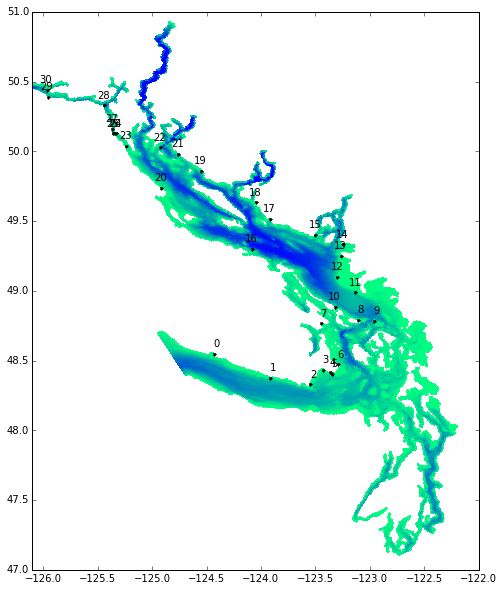

In [21]:
fig,ax=plt.subplots(1, 1, figsize=(8, 10))
ax.pcolormesh(X,Y,bathy,cmap='winter_r')

for stn in range(numsta):
    location = stations_obs[stn]
    lon=-harm_obs.lon[harm_obs.site==location]
    lat=harm_obs.lat[harm_obs.site==location]
    ax.plot(lon,lat,'.k',label=location)
    ax.annotate(stn, xy = (lon,lat), xytext = (5,5),ha = 'right', va = 'bottom',
        textcoords = 'offset points')
ax.axis([-126.1,-122,47,51])

# Tidal Harmonics

In [22]:
# M2
M2freq = 28.984106 # degrees per hour
M2freq = M2freq*np.pi/180. # radians per hour
#K1
K1freq = 15.041069*np.pi/180.
#O1
O1freq = 13.943036*np.pi/180.
#S2
S2freq = 30.000002*np.pi/180.
#P1
P1freq = 14.958932*np.pi/180.
#N2
N2freq = 28.439730*np.pi/180.
#Q1
Q1freq = 13.398661*np.pi/180.
#K2
K2freq = 30.082138*np.pi/180.

if runname == 'corr15':
    K1ft = 1.050578
    K1uvt = 296.314842
    M2ft = 0.987843
    M2uvt = 245.888564
    O1ft = 1.081364
    O1uvt = 312.950020
    S2ft = 1.0
    S2uvt = 0.0
    P1ft = 1.0
    P1uvt = 55.79460
    N2ft = 0.98784
    N2uvt = 353.570277
    Q1ft = 1.081364
    Q1uvt = 60.631733
    K2ft = 1.114095
    K2uvt = 52.129248
else:
    K1ft = 1.065505
    K1uvt = 111.481741
    M2ft = 0.982328
    M2uvt = 250.506179
    O1ft = 1.105495
    O1uvt = 142.040782
    S2ft = 1.000000  
    S2uvt = 0.000000
    P1ft = 1.000000
    P1uvt = 241.335269
    N2ft = 0.982328
    N2uvt = 205.684028
    Q1ft = 1.105495 
    Q1uvt = 97.218631
    K2ft = 1.159036 
    K2uvt = 42.361669

In [23]:
# function for fit
def double(x, M2amp, M2pha, K1amp, K1pha):
    return (M2amp*np.cos(M2freq*x-M2pha*np.pi/180.)+
            K1amp*np.cos(K1freq*x-K1pha*np.pi/180.))

# function for fitting 3 frequencies
def triple(x, M2amp, M2pha, K1amp, K1pha, O1amp, O1pha):
    return (M2amp*np.cos(M2freq*x-M2pha*np.pi/180.)+
            K1amp*np.cos(K1freq*x-K1pha*np.pi/180.)+
            O1amp*np.cos(O1freq*x-O1pha*np.pi/180.))

# function for fitting 4 frequencies
def quad(x, M2amp, M2pha, K1amp, K1pha, O1amp, O1pha, S2amp, S2pha):
    return (M2amp*np.cos(M2freq*x-M2pha*np.pi/180.)+
            K1amp*np.cos(K1freq*x-K1pha*np.pi/180.)+
            O1amp*np.cos(O1freq*x-O1pha*np.pi/180.)+
            S2amp*np.cos(S2freq*x-S2pha*np.pi/180.))

# function for fitting 6 frequencies
def sextuple(x, M2amp, M2pha, K1amp, K1pha, O1amp, O1pha, S2amp, S2pha,
                 P1amp, P1pha, N2amp, N2pha):
    return (M2amp*np.cos(M2freq*x-M2pha*np.pi/180.)+
            K1amp*np.cos(K1freq*x-K1pha*np.pi/180.)+
            O1amp*np.cos(O1freq*x-O1pha*np.pi/180.)+
            S2amp*np.cos(S2freq*x-S2pha*np.pi/180.)+
            P1amp*np.cos(P1freq*x-P1pha*np.pi/180.)+
            N2amp*np.cos(N2freq*x-N2pha*np.pi/180.))

# function for fitting 8 frequencies
def octuple(x, M2amp, M2pha, K1amp, K1pha, O1amp, O1pha, S2amp, S2pha,
                 P1amp, P1pha, N2amp, N2pha, Q1amp, Q1pha, K2amp, K2pha):
    return (M2amp*np.cos(M2freq*x-M2pha*np.pi/180.)+
            K1amp*np.cos(K1freq*x-K1pha*np.pi/180.)+
            O1amp*np.cos(O1freq*x-O1pha*np.pi/180.)+
            S2amp*np.cos(S2freq*x-S2pha*np.pi/180.)+
            P1amp*np.cos(P1freq*x-P1pha*np.pi/180.)+
            N2amp*np.cos(N2freq*x-N2pha*np.pi/180.)+
            Q1amp*np.cos(Q1freq*x-Q1pha*np.pi/180.)+
            K2amp*np.cos(K2freq*x-K2pha*np.pi/180.))

PortRenfrew
Victoria
PointAtkinson
CampbellRiver


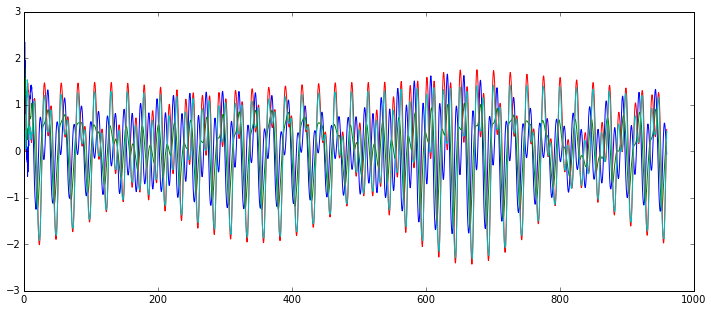

In [24]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
for stn in (0,4,14,23):
    print stations[stn]
    fT1 = NC.Dataset(name+stations[stn]+'.nc','r')
    time = fT1.variables["time_counter"][:]/3600.  # want hours not seconds
    ssh = fT1.variables["sossheig"][:,0,0]
    ax.plot(time,ssh)

In [25]:
#allocate space for our arrays
M2_amp=[]; M2_pha=[]; K1_amp=[]; K1_pha=[]
O1_amp=[]; O1_pha=[]; S2_amp=[]; S2_pha=[]
P1_amp=[]; P1_pha=[]; N2_amp=[]; N2_pha=[]
Q1_amp=[]; Q1_pha=[]; K2_amp=[]; K2_pha=[]

M2_amp_obs=np.zeros(numsta); M2_pha_obs=np.zeros(numsta)
K1_amp_obs=np.zeros(numsta); K1_pha_obs=np.zeros(numsta)
O1_amp_obs=np.zeros(numsta); O1_pha_obs=np.zeros(numsta)
S2_amp_obs=np.zeros(numsta); S2_pha_obs=np.zeros(numsta)
P1_amp_obs=np.zeros(numsta); P1_pha_obs=np.zeros(numsta)
N2_amp_obs=np.zeros(numsta); N2_pha_obs=np.zeros(numsta)
Q1_amp_obs=np.zeros(numsta); Q1_pha_obs=np.zeros(numsta)
K2_amp_obs=np.zeros(numsta); K2_pha_obs=np.zeros(numsta)

ts = 240
te = ssh.shape[0]

  
for stn in range(numsta):
    fT1 = NC.Dataset(name+stations[stn]+'.nc','r')
    time = fT1.variables["time_counter"][:]/3600.  # want hours not seconds
    ssh = fT1.variables["sossheig"][:,0,0]

    fitted, cov = curve_fit(octuple,time[ts:te],ssh[ts:te]) 
    if fitted[0] < 0:
        fitted[0] = -fitted[0]
        fitted[1] = fitted[1]+180

    M2_amp.append(fitted[0]*M2ft)
    pha = fitted[1]+M2uvt
    if  pha > 360:
        pha=pha-360
    elif pha < 0:
        pha = pha+360
    if stn == 6:
        print pha
    M2_pha.append(pha)

    if fitted[2] < 0:
        fitted[2] = - fitted[2]
        fitted[3] = fitted[3] + 180
    K1_amp.append(fitted[2]*K1ft)
    pha = fitted[3] + K1uvt
    if  pha > 360:
        pha = pha-360
    K1_pha.append(pha)  
    
    if fitted[4] < 0:
        fitted[4] = -fitted[4]
        fitted[5] = fitted[5]+180
    O1_amp.append(fitted[4]*O1ft)
    pha= fitted[5]+O1uvt
    if  pha > 360:
        pha=pha-360
    O1_pha.append(pha) 
    
    if fitted[6] < 0:
        fitted[6] = -fitted[6]
        fitted[7] = fitted[7]+180
    S2_amp.append(fitted[6]*S2ft)
    pha= fitted[7]+S2uvt
    if  pha > 360:
        pha=pha-360
    S2_pha.append(pha) 
    
    if fitted[8] < 0:
            fitted[8] = -fitted[8]
            fitted[9] = fitted[9]+180
    P1_amp.append(fitted[8]*P1ft)
    pha= fitted[9]+P1uvt
    if  pha > 360:
        pha=pha-360
    P1_pha.append(pha) 
    
    if fitted[10] < 0:
            fitted[10] = -fitted[10]
            fitted[11] = fitted[11]+180
    N2_amp.append(fitted[10]*N2ft)
    pha= fitted[11]+N2uvt
    if  pha > 360:
        pha=pha-360
    N2_pha.append(pha) 
    
    if fitted[12] < 0:
            fitted[12] = -fitted[12]
            fitted[13] = fitted[13]+180
    Q1_amp.append(fitted[12]*Q1ft)
    pha= fitted[13]+Q1uvt
    if  pha > 360:
        pha=pha-360
    Q1_pha.append(pha) 
    
    if fitted[14] < 0:
            fitted[14] = -fitted[14]
            fitted[15] = fitted[15]+180
    K2_amp.append(fitted[14]*K2ft)
    pha= fitted[15]+K2uvt
    if pha > 360:
        pha = pha-360
    if pha < 0:
        pha = pha + 360
    K2_pha.append(pha) 

    #now the observations
    location=stations_obs[stn]
    M2_amp_obs[stn]=harm_obs.M2_amp[harm_obs.site==location]/100
    M2_pha_obs[stn]=harm_obs.M2_pha[harm_obs.site==location]
    K1_amp_obs[stn]=harm_obs.K1_amp[harm_obs.site==location]/100
    K1_pha_obs[stn]=harm_obs.K1_pha[harm_obs.site==location]
    
    #O1/S2/P1/N2/Q1/K2 are in the other file
    if (harm_other.site==location).any():
        O1_amp_obs[stn]=harm_other.O1_amp[harm_other.site==location]/100
        O1_pha_obs[stn]=harm_other.O1_pha[harm_other.site==location]
        S2_amp_obs[stn]=harm_other.S2_amp[harm_other.site==location]/100
        S2_pha_obs[stn]=harm_other.S2_pha[harm_other.site==location]
        P1_amp_obs[stn]=harm_other.P1_amp[harm_other.site==location]/100
        P1_pha_obs[stn]=harm_other.P1_pha[harm_other.site==location]
        N2_amp_obs[stn]=harm_other.N2_amp[harm_other.site==location]/100
        N2_pha_obs[stn]=harm_other.N2_pha[harm_other.site==location]
        Q1_amp_obs[stn]=harm_other.Q1_amp[harm_other.site==location]/100
        Q1_pha_obs[stn]=harm_other.Q1_pha[harm_other.site==location]
        K2_amp_obs[stn]=harm_other.K2_amp[harm_other.site==location]/100
        K2_pha_obs[stn]=harm_other.K2_pha[harm_other.site==location]
    #Mask the arrays so that we can do statistics without the 0's throwing thigns off.
    O1_amp_obs =np.ma.masked_values(O1_amp_obs, 0)
    O1_pha_obs =np.ma.masked_values(O1_pha_obs, 0)
    S2_amp_obs =np.ma.masked_values(S2_amp_obs, 0)
    S2_pha_obs =np.ma.masked_values(S2_pha_obs, 0)
    P1_amp_obs =np.ma.masked_values(P1_amp_obs, 0)
    P1_pha_obs =np.ma.masked_values(P1_pha_obs, 0)
    N2_amp_obs =np.ma.masked_values(N2_amp_obs, 0)
    N2_pha_obs =np.ma.masked_values(N2_pha_obs, 0)
    Q1_amp_obs =np.ma.masked_values(Q1_amp_obs, 0)
    Q1_pha_obs =np.ma.masked_values(Q1_pha_obs, 0)
    K2_amp_obs =np.ma.masked_values(K2_amp_obs, 0)
    K2_pha_obs =np.ma.masked_values(K2_pha_obs, 0)
    
print harm_other

349.389283208
                  site     lat      lon  O1_amp  O1_pha  P1_amp  P1_pha  \
0             Neah Bay  48.385 -124.616   30.90  231.50   15.50  244.60   
1         Port Renfrew  48.537 -124.476   28.30  234.80   14.07  250.60   
2         Port Angeles  48.129 -123.400   39.10  241.60   20.70  259.40   
3             Victoria  48.413 -123.399   37.00  247.80   19.70  264.60   
4        Port Townsend  48.112 -122.758   45.00  249.90   23.90  268.40   
5               Bangor  47.748 -122.727   46.60  251.90   26.00  273.90   
6              Seattle  47.605 -122.338   45.80  255.40   25.20  274.50   
7               Tacoma  47.267 -122.413   45.90  255.10   25.50  277.20   
8         Cherry Point  48.863 -122.758   45.60  260.00   25.60  281.40   
9        Friday Harbor  48.540 -123.010   42.30  256.40   23.60  274.90   
10       Hanbury Point  48.580 -123.172   43.60  253.60   23.40  271.40   
11              Sidney  48.658 -123.383   44.40  255.80   24.20  275.20   
12     Fulf

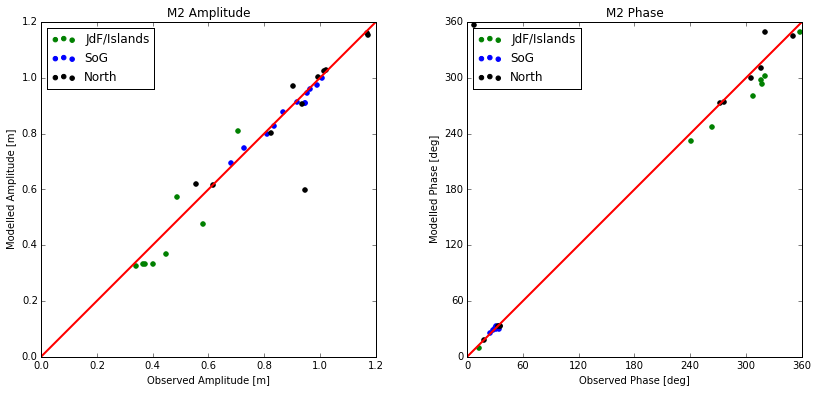

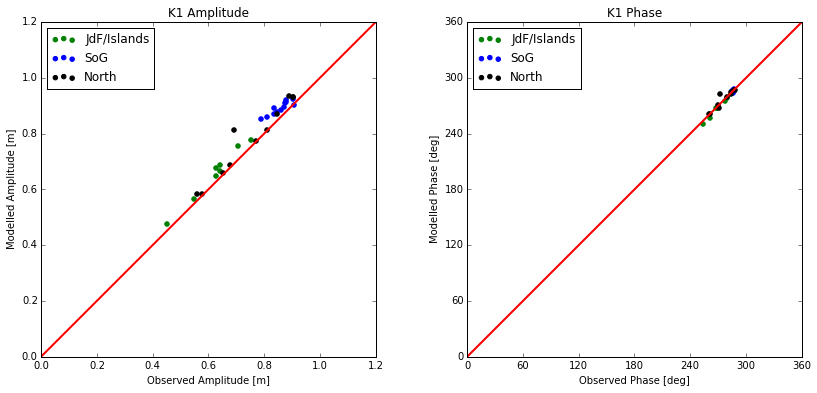

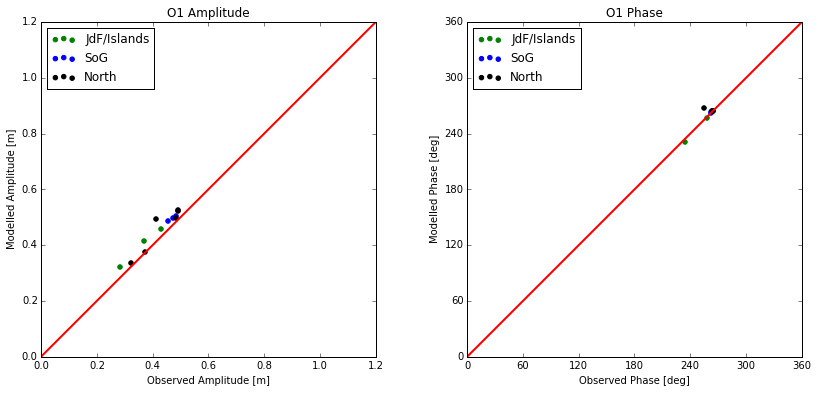

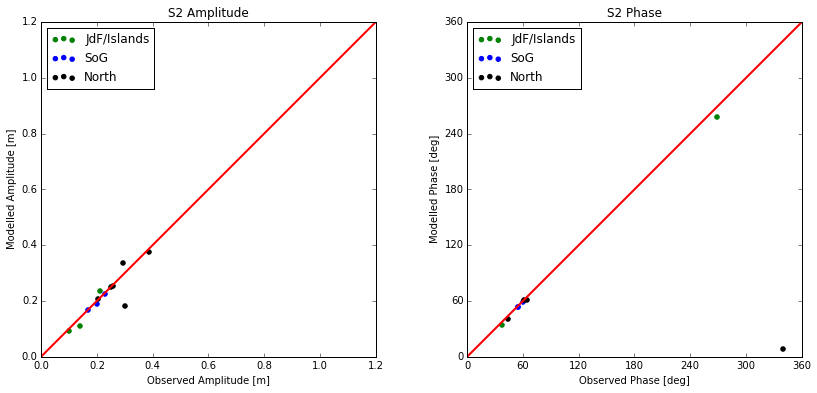

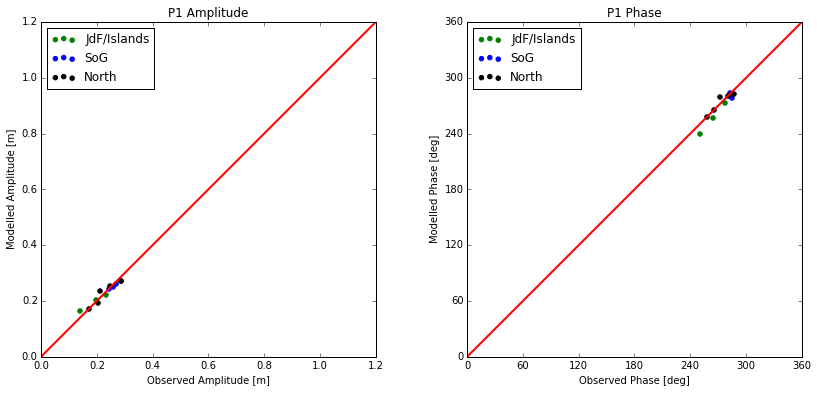

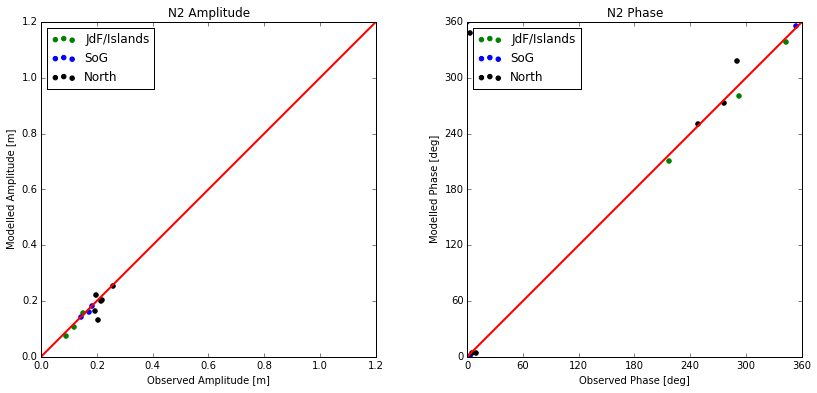

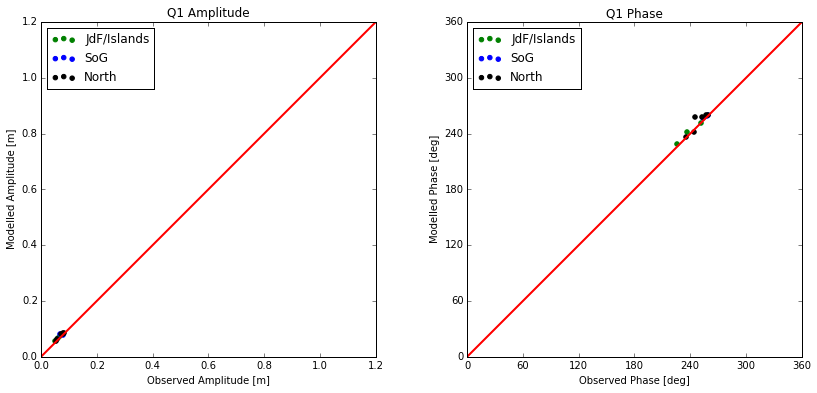

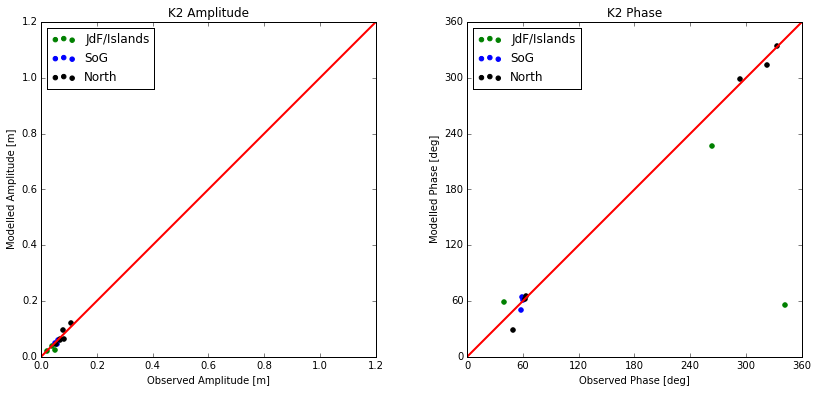

In [26]:
labels=['JdF/Islands','SoG','North']
split1=8; split2=20

#Plotting M2
fig=tidetools.plot_scatter_pha_amp(M2_amp,M2_amp_obs,M2_pha,M2_pha_obs,'M2',figsize=(14,6),
                                   split1=split1,split2=split2, labels=labels)
ax_amp,ax_pha = fig.axes
min_value, max_value = ax_amp.set_xlim(0, 1.2)
ax_amp.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)
min_value, max_value = ax_pha.set_xlim(0, 360)
ax_pha.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)

#Plotting K1
fig=tidetools.plot_scatter_pha_amp(K1_amp,K1_amp_obs,K1_pha,K1_pha_obs,'K1',figsize=(14,6),
                                   split1=split1, split2=split2, labels=labels)
ax_amp,ax_pha = fig.axes
min_value, max_value = ax_amp.set_xlim(0, 1.2)
ax_amp.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)
min_value, max_value = ax_pha.set_xlim(0, 360)
ax_pha.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)

#Plotting O1
fig=tidetools.plot_scatter_pha_amp(O1_amp,O1_amp_obs,O1_pha,O1_pha_obs,'O1',figsize=(14,6),
                                   split1=split1, split2=split2, labels=labels)
ax_amp,ax_pha = fig.axes
min_value, max_value = ax_amp.set_xlim(0, 1.2)
ax_amp.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)
min_value, max_value = ax_pha.set_xlim(0, 360)
ax_pha.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)

#Plotting S2
fig=tidetools.plot_scatter_pha_amp(S2_amp,S2_amp_obs,S2_pha,S2_pha_obs,'S2',figsize=(14,6),
                                   split1=split1, split2=split2, labels=labels)
ax_amp,ax_pha = fig.axes
min_value, max_value = ax_amp.set_xlim(0, 1.2)
ax_amp.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)
min_value, max_value = ax_pha.set_xlim(0, 360)
ax_pha.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)

#Plotting P1
fig=tidetools.plot_scatter_pha_amp(P1_amp,P1_amp_obs,P1_pha,P1_pha_obs,'P1',figsize=(14,6),
                                   split1=split1, split2=split2, labels=labels)
ax_amp,ax_pha = fig.axes
min_value, max_value = ax_amp.set_xlim(0, 1.2)
ax_amp.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)
min_value, max_value = ax_pha.set_xlim(0, 360)
ax_pha.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)

#Plotting N2
fig=tidetools.plot_scatter_pha_amp(N2_amp,N2_amp_obs,N2_pha,N2_pha_obs,'N2',figsize=(14,6),
                                   split1=split1, split2=split2, labels=labels)
ax_amp,ax_pha = fig.axes
min_value, max_value = ax_amp.set_xlim(0, 1.2)
ax_amp.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)
min_value, max_value = ax_pha.set_xlim(0, 360)
ax_pha.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)

#Plotting Q1
fig=tidetools.plot_scatter_pha_amp(Q1_amp,Q1_amp_obs,Q1_pha,Q1_pha_obs,'Q1',figsize=(14,6),
                                   split1=split1, split2=split2, labels=labels)
ax_amp,ax_pha = fig.axes
min_value, max_value = ax_amp.set_xlim(0, 1.2)
ax_amp.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)
min_value, max_value = ax_pha.set_xlim(0, 360)
ax_pha.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)

#Plotting K2
fig=tidetools.plot_scatter_pha_amp(K2_amp,K2_amp_obs,K2_pha,K2_pha_obs,'K2',figsize=(14,6),
                                   split1=split1, split2=split2, labels=labels)
ax_amp,ax_pha = fig.axes
min_value, max_value = ax_amp.set_xlim(0, 1.2)
ax_amp.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)
min_value, max_value = ax_pha.set_xlim(0, 360)
ax_pha.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)

# Statistics

Some other things we will look at are

$R = \frac{A_m}{A_o}$, the ratio of modelled to observed amplitude and 

$\Delta \phi = \phi_m - \phi_o$, the difference betwen modelled and observed phase.

In [27]:
# mean error (absolute value)
def mean(diff):
    return np.mean(abs(diff))

# rms error
def rms(diff):
    return np.sqrt(np.mean(diff**2))

# complex difference
def complex_diff(Ao,go,Am,gm):
    #calculates complex differences between observations and model
    #Ao, go - amplitude and phase from observations
    #Am, gm - amplitude and phase from model
    D = np.sqrt((Ao*np.cos(np.pi*go/180)-Am*np.cos(np.pi*gm/180))**2 + 
                (Ao*np.sin(np.pi*go/180)-Am*np.sin(np.pi*gm/180))**2)
    return D

In [28]:
#R
R_M2 = M2_amp/M2_amp_obs
R_K1 = K1_amp/K1_amp_obs
#delta phi (adjust so between -180, 180)
Dphi_M2 = M2_pha-M2_pha_obs; 
Dphi_M2 = Dphi_M2 -360*(Dphi_M2>180) + 360*(Dphi_M2<-180)
Dphi_K1 = K1_pha-K1_pha_obs
Dphi_K1 = Dphi_K1 -360*(Dphi_K1>180) + 360*(Dphi_K1<-180)
#Complex differences
D_M2= complex_diff(np.array(M2_amp_obs),np.array(M2_pha_obs), np.array(M2_amp),np.array(M2_pha))
D_K1= complex_diff(np.array(K1_amp_obs),np.array(K1_pha_obs), np.array(K1_amp),np.array(K1_pha))
D_O1= complex_diff(np.ma.array(O1_amp_obs),np.ma.array(O1_pha_obs), np.ma.array(O1_amp),np.ma.array(O1_pha))
D_S2= complex_diff(np.ma.array(S2_amp_obs),np.ma.array(S2_pha_obs), np.ma.array(S2_amp),np.ma.array(S2_pha))
D_P1= complex_diff(np.ma.array(P1_amp_obs),np.ma.array(P1_pha_obs), np.ma.array(P1_amp),np.ma.array(P1_pha))
D_N2= complex_diff(np.ma.array(N2_amp_obs),np.ma.array(N2_pha_obs), np.ma.array(N2_amp),np.ma.array(N2_pha))
D_Q1= complex_diff(np.ma.array(Q1_amp_obs),np.ma.array(Q1_pha_obs), np.ma.array(Q1_amp),np.ma.array(Q1_pha))
D_K2= complex_diff(np.ma.array(K2_amp_obs),np.ma.array(K2_pha_obs), np.ma.array(K2_amp),np.ma.array(K2_pha))

# Saving Results

In [29]:
type(D_M2), type(M2_amp), type(np.array(M2_amp))

(numpy.ndarray, list, numpy.ndarray)

In [30]:
outfile = runname+'.csv'

with open(outfile, 'wb') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['Station Name', 
                     'M2(Amp)', 'M2(Pha)', 'M2(D)', 
                     'K1(Amp)', 'K1(Pha)', 'K1(D)',
                     'O1(Amp)', 'O1(Pha)', 'O1(D)',
                     'S2(Amp)', 'S2(Pha)', 'S2(D)',
                     'P1(Amp)', 'P1(Pha)', 'P1(D)',
                     'N2(Amp)', 'N2(Pha)', 'N2(D)',
                     'Q1(Amp)', 'Q1(Pha)', 'Q1(D)',
                     'K2(Amp)', 'K2(Pha)', 'K2(D)'])
    for stn in range(numsta):
        location = stations_obs[stn]
        writer.writerow([stations_obs[stn], 
                         M2_amp[stn], M2_pha[stn], D_M2[stn], 
                         K1_amp[stn], K1_pha[stn], D_K1[stn],
                         O1_amp[stn], O1_pha[stn], D_O1[stn],
                         S2_amp[stn], S2_pha[stn], D_S2[stn],
                         P1_amp[stn], P1_pha[stn], D_P1[stn],
                         N2_amp[stn], N2_pha[stn], D_N2[stn],
                         Q1_amp[stn], Q1_pha[stn], D_Q1[stn],
                         K2_amp[stn], K2_pha[stn], D_K2[stn]])

# Analysis

load csv files that can be created by code above

In [32]:
tides_test2retry= pd.read_csv('tides_test2retry.csv', na_values=['--'])
tides_test = pd.read_csv('tides_test.csv', na_values=['--'])
oldtopog = pd.read_csv('oldtopog.csv', na_values=['--'])
corr15 = pd.read_csv('corr15.csv', na_values=['--'])

In [33]:
vars_cols = list(tides_test.columns.values)
vars_cols

['Station Name',
 'M2(Amp)',
 'M2(Pha)',
 'M2(D)',
 'K1(Amp)',
 'K1(Pha)',
 'K1(D)',
 'O1(Amp)',
 'O1(Pha)',
 'O1(D)',
 'S2(Amp)',
 'S2(Pha)',
 'S2(D)',
 'P1(Amp)',
 'P1(Pha)',
 'P1(D)',
 'N2(Amp)',
 'N2(Pha)',
 'N2(D)',
 'Q1(Amp)',
 'Q1(Pha)',
 'Q1(D)',
 'K2(Amp)',
 'K2(Pha)',
 'K2(D)']

In [34]:
corr15.head()

,Station Name,M2(Amp),M2(Pha),M2(D),K1(Amp),K1(Pha),K1(D),O1(Amp),O1(Pha),O1(D),...,P1(D),N2(Amp),N2(Pha),N2(D),Q1(Amp),Q1(Pha),Q1(D),K2(Amp),K2(Pha),K2(D)
0,Port Renfrew,0.817966,231.700873,0.166260,0.466202,249.164056,0.041722,0.308096,231.342385,0.030778,...,0.030804,0.156462,210.229591,0.019625,0.050599,-134.445596,0.000364,0.029756,229.383933,0.029505
1,Sheringham Point,0.581797,246.834627,0.179513,0.547756,257.059732,0.042449,0.350949,237.794760,NaN,...,NaN,0.115458,227.846566,NaN,0.057137,230.969453,NaN,0.013808,231.168925,NaN
2,Pedder Bay,0.327215,280.613457,0.159069,0.623370,266.587078,0.026576,0.386244,246.178001,NaN,...,NaN,0.072804,623.742276,NaN,0.060895,239.808689,NaN,0.009892,23.186452,NaN
3,Esquimalt,0.333019,294.011136,0.143995,0.639732,267.055657,0.012138,0.391354,245.724712,NaN,...,NaN,0.076632,-84.623244,NaN,0.061439,240.115392,NaN,0.009831,61.947266,NaN
4,Victoria,0.331820,298.329456,0.116218,0.651849,267.370314,0.032160,0.399084,247.131954,0.029427,...,0.018671,0.077399,278.790760,0.023616,0.062777,240.884808,0.005565,0.012672,50.204416,0.019318


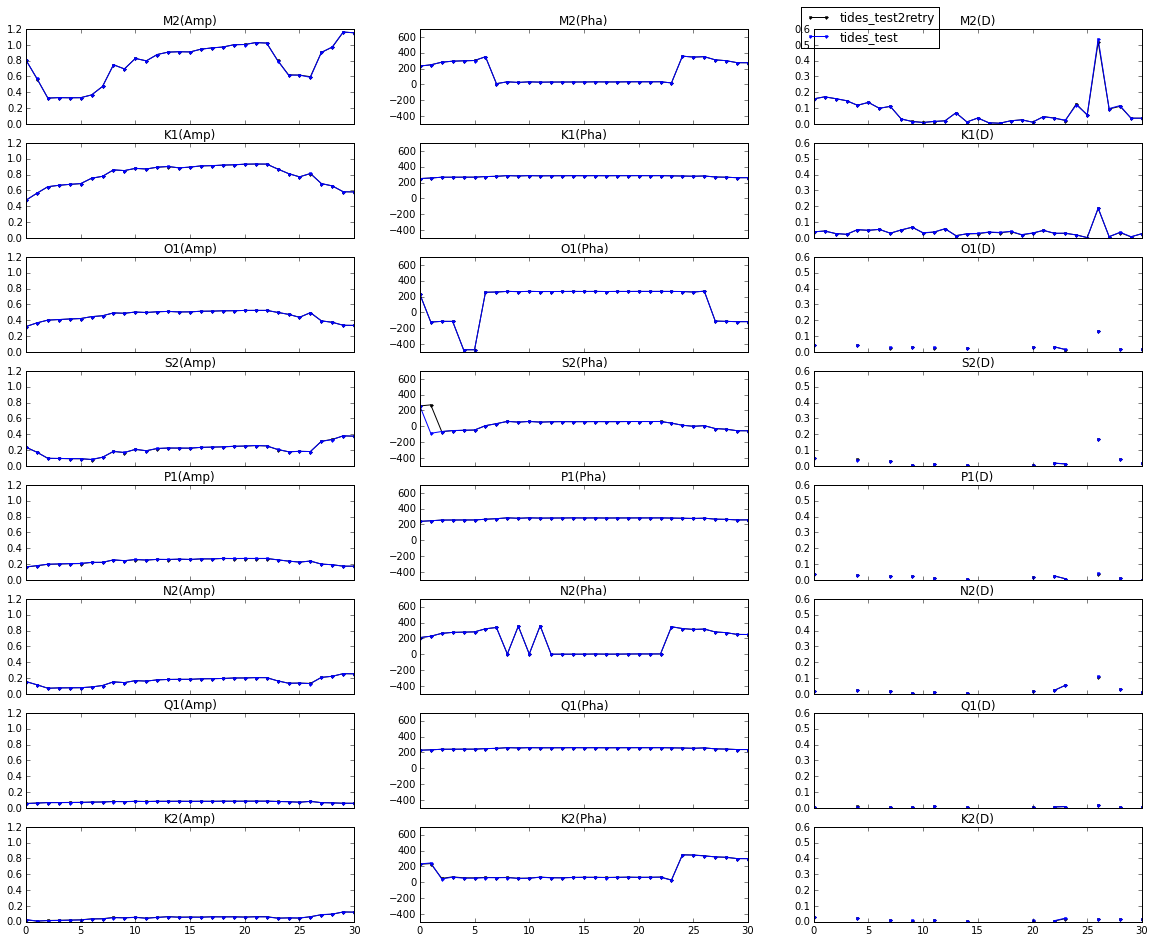

In [37]:
comps_all = [['M2(Amp)', 'M2(Pha)', 'M2(D)'],
             ['K1(Amp)', 'K1(Pha)', 'K1(D)'],
             ['O1(Amp)', 'O1(Pha)', 'O1(D)'],
             ['S2(Amp)', 'S2(Pha)', 'S2(D)'],
             ['P1(Amp)', 'P1(Pha)','P1(D)'],
             ['N2(Amp)', 'N2(Pha)','N2(D)'],
             ['Q1(Amp)', 'Q1(Pha)','Q1(D)'],
             ['K2(Amp)', 'K2(Pha)','K2(D)']]

fig,axs = plt.subplots(8,3,figsize=(20,16), sharex=True)

for N in np.arange(len(comps_all)):
    comp_one = comps_all[N]
    for comp, n in zip(comp_one, np.arange(len(comp_one))):
        axs[N,n].plot(tides_test2retry[comp], '.-k', label='tides_test2retry')
        axs[N,n].plot(tides_test[comp], '.-b', label='tides_test')
        #axs[N,n].plot(oldtopog[comp], '.-g', label='oldtopog')
        #axs[N,n].plot(corr15[comp], '.-r', label='corr15')
        axs[N,n].set_title([comp][0])
        axs[N,0].set_ylim(0.0,1.2)
        axs[N,1].set_ylim(-500,700)
        axs[N,2].set_ylim(0.0,0.6)
axs[0,2].legend(bbox_to_anchor=(0.4, 1.3), ncol=1)

Difference: tidal analysis with ssh anomaly forcing and without


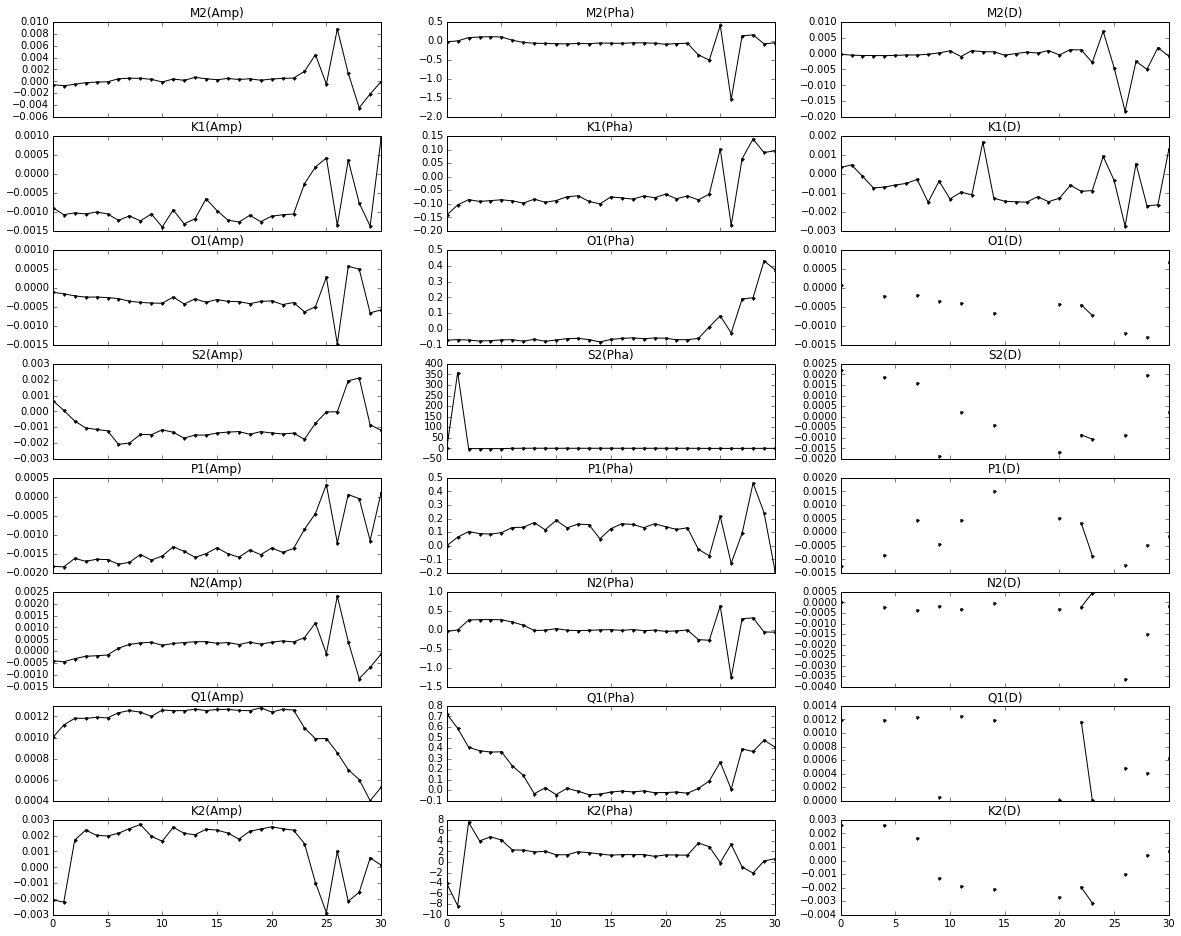

In [41]:
fig,axs = plt.subplots(8,3,figsize=(20,16), sharex=True)

print 'Difference: tidal analysis with ssh anomaly forcing and without'
for N in np.arange(len(comps_all)):
    comp_one = comps_all[N]
    for comp, n in zip(comp_one, np.arange(len(comp_one))):
        axs[N,n].plot(tides_test2retry[comp] - tides_test[comp], '.-k')    
        axs[N,n].set_title([comp][0])
        #axs[N,0].set_ylim(0.0,1.2)
        #axs[N,1].set_ylim(-500,700)
        #axs[N,2].set_ylim(0.0,0.6)
axs[0,2].legend(bbox_to_anchor=(0.4, 1.3), ncol=1)

Very small differences (typically less than a cm amplitude change for M2/K1). Largest differences in the Johnstone Strait region. M2 complex diffences change by less than 2 cm. K1 is less than 5 mm. M2 phase is well behaved, but up to 1 degree difference in Johnstone Strait.